<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Decision Tree**


Estimated time needed: **30** minutes


In this lab, you will learn and practice the decision tree model. Decision tree model outputs a set of rules, and each rule is a If-else chain from root to a leaf node. **Decision tree mimics human reasoning** process which makes it very intuitive to human users and makes it a high-interpretable model.


We will be using a tumor sample dataset, which contains lab test results about tumor samples. The objective is to classify whether a tumor is malicious (cancer) or benign. As such, it is a typical binary classification task.


## Objectives


After completing this lab you will be able to:


*   Train decision tree models with customized hyperparameters
*   Evaluate decision tree models on classification tasks
*   Visualize decision tree models by plotting the tree
*   Tune the hyperparameters to find the optimized one for a specific task


***


## Lab Environment Setup


Instal and import required packages


In [1]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !mamba install -qy pandas==1.3.3 numpy==1.21.2 ipywidgets==7.4.2 scipy==7.4.2 tqdm==4.62.3 matplotlib==3.5.0 seaborn==0.9.0
# Note: If your environment doesn't support "!mamba install", use "!pip install" 

In [2]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
# Evaluation metrics related methods
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
rs = 123

## Load and explore the tumor dataset


First, let's load the tumor dataset as a Pandas dataframe


In [4]:
dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/tumor.csv"
tumor_df = pd.read_csv(dataset_url)

And check its dataframe head


In [5]:
tumor_df.head()

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0


Each observation in this dataset contains lab tests results about a tumor sample, such as clump or shapes. Based on these lab test results or features, we want to build a classification model to predict if this tumor sample is malicious (cancer) and benign. The target variable `y` is specified in the `Class` column.


Then, let's split the dataframe into train and testing data


In [6]:
# Get the input features
X = tumor_df.iloc[:, :-1]
# Get the target variable
y = tumor_df.iloc[:, -1:]

In [7]:
# Split the training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = rs)

### Train a default decision tree


Training a decision classifier is very straightforward with `sklearn`, we first need to define a `DecisionTreeClassifier` object. In the first step, we will use all the default arguments.


In [8]:
# Train a decision tree with all default arguments
model = DecisionTreeClassifier(random_state=rs)

Then we can train the decision tree model with training and testing data


In [9]:
model.fit(X_train, y_train.values.ravel()) #.ravel change the df to an array

DecisionTreeClassifier(random_state=123)

And make predictions on the test data


In [10]:
preds = model.predict(X_test)

Here we also provided a utility method to evaluate the trained decision tree model and output some standard evaluation metrics.


In [11]:
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, average='binary')
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

In [12]:
evaluate_metrics(y_test, preds)

{'accuracy': 0.9562043795620438,
 'recall': 0.9583333333333334,
 'precision': 0.92,
 'f1score': 0.9387755102040817}

Now we can see that the trained decision model has very good classification results on the testing data, with a very high F1 score around 0.94. Next, let's try to visualize and interpret the trained decision tree model.


## Visualize the trained decision tree


We will be using the `tree.plot_tree()` method provided by `sklearn` to quickly plot any decision tree model.


In [13]:
def plot_decision_tree(model, feature_names):
    plt.subplots(figsize=(25, 20)) 
    tree.plot_tree(model, 
                       feature_names=feature_names,  
                       filled=True)
    plt.show()

In [14]:
feature_names = X.columns.values # using columns names instead of index

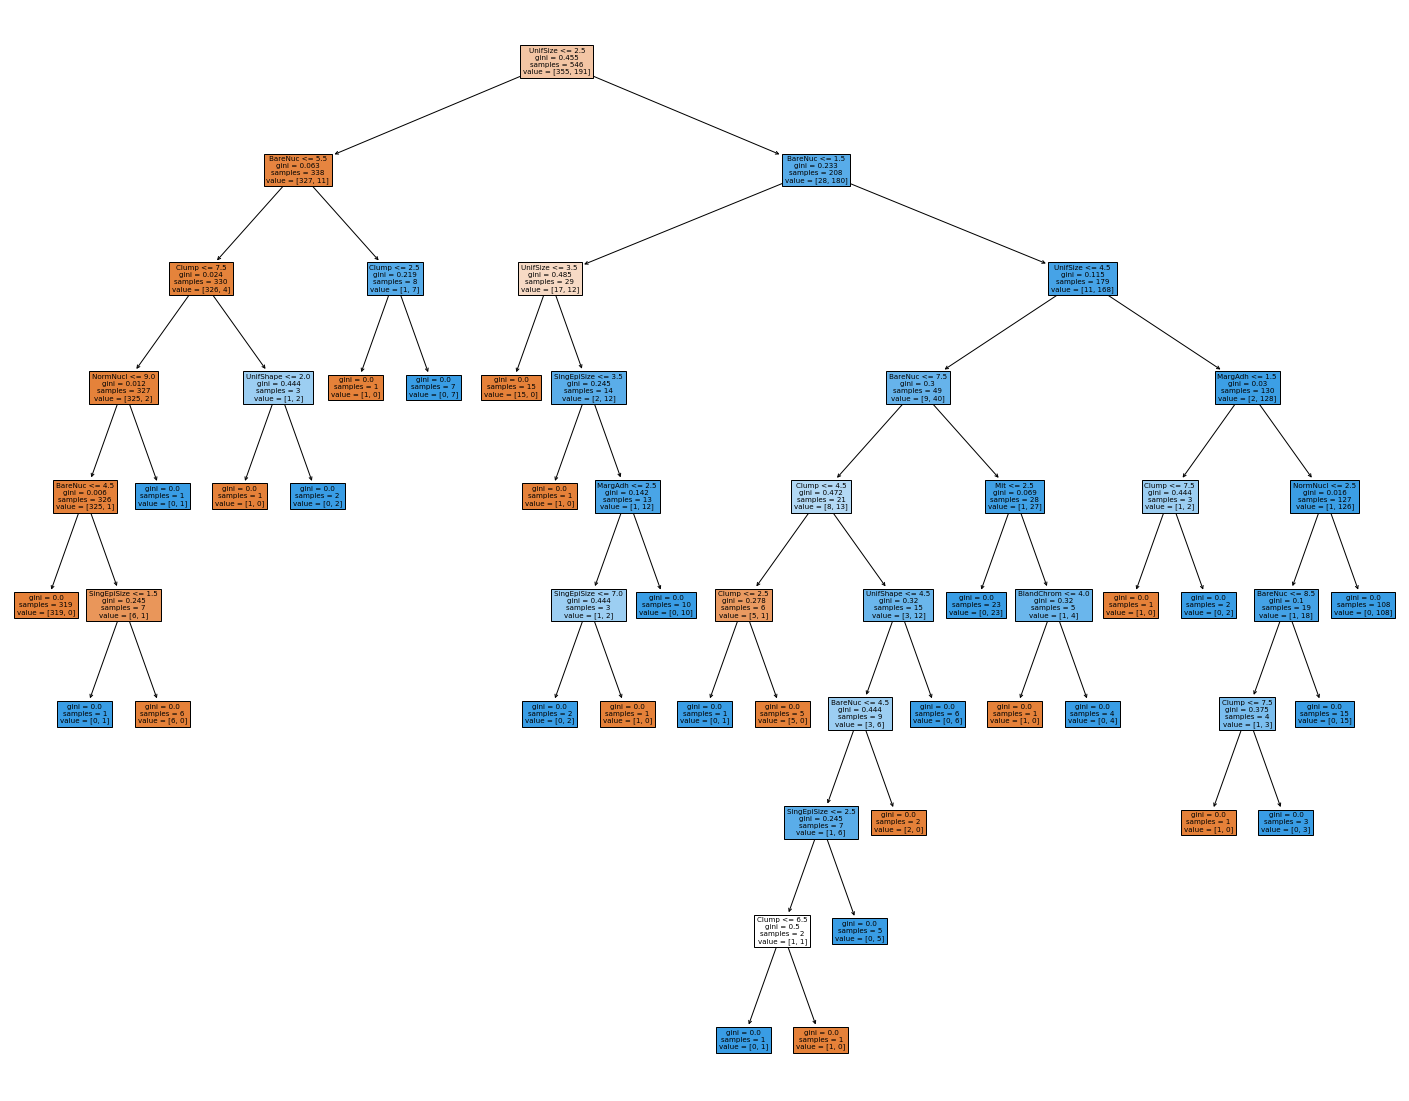

In [15]:
plot_decision_tree(model, feature_names)

And you should see a relatively complex decision tree model being plotted. First, you may notice the decision tree is color-labeled, orange node means a majority of samples in the node belong to `Class 0` and blue node means a majority of samples in the node belong to `Class 1`, and white node means it has an equal amount of `Class 0` and `Class 1` samples.


Because the tree is very big, so the rules and split threshold on each node are very difficult to see. In addition, big decision trees may easily bring large variance and cause overfitting. Next, let's try to build simplified decision trees, and hopefully the simplified decision trees may generate even better results.


## Cutomize the decision tree model


The `DecisionTreeClassifier` has many arguments (model hyperparameters) that can be customized and eventually tune the generated decision tree classifiers. Among these arguments, there are three commonly tuned arguments as follows:

*   criterion: `gini` or `entropy`, which specifies which criteria to be used when splitting a tree node
*   max_depth: a numeric value to specify the max depth of the tree. Larger tree depth normally means larger model complexity
*   min_samples_leaf: The minimal number of samples in leaf nodes. Larger samples in leaf nodes will tend to generate simpler trees


Let's first try the following hyperparameter values:

*   criterion = 'entropy'
*   max_depth = 10
*   min_samples_leaf=5


In [16]:
# criterion = 'entropy'
# max_depth = 10
# min_samples_leaf=5
custom_model = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=3, random_state=rs)

And let's train and evaluate the customized model


In [17]:
custom_model.fit(X_train, y_train.values.ravel())
preds = custom_model.predict(X_test)
evaluate_metrics(y_test, preds)

{'accuracy': 0.9635036496350365,
 'recall': 0.9166666666666666,
 'precision': 0.9777777777777777,
 'f1score': 0.946236559139785}

Its F1 score has increased to 0.946 now, which seems better than the previous default decision tree model.


Then, let's visualize the custom model using plot_decision_tree() utility method we created in the previous step:


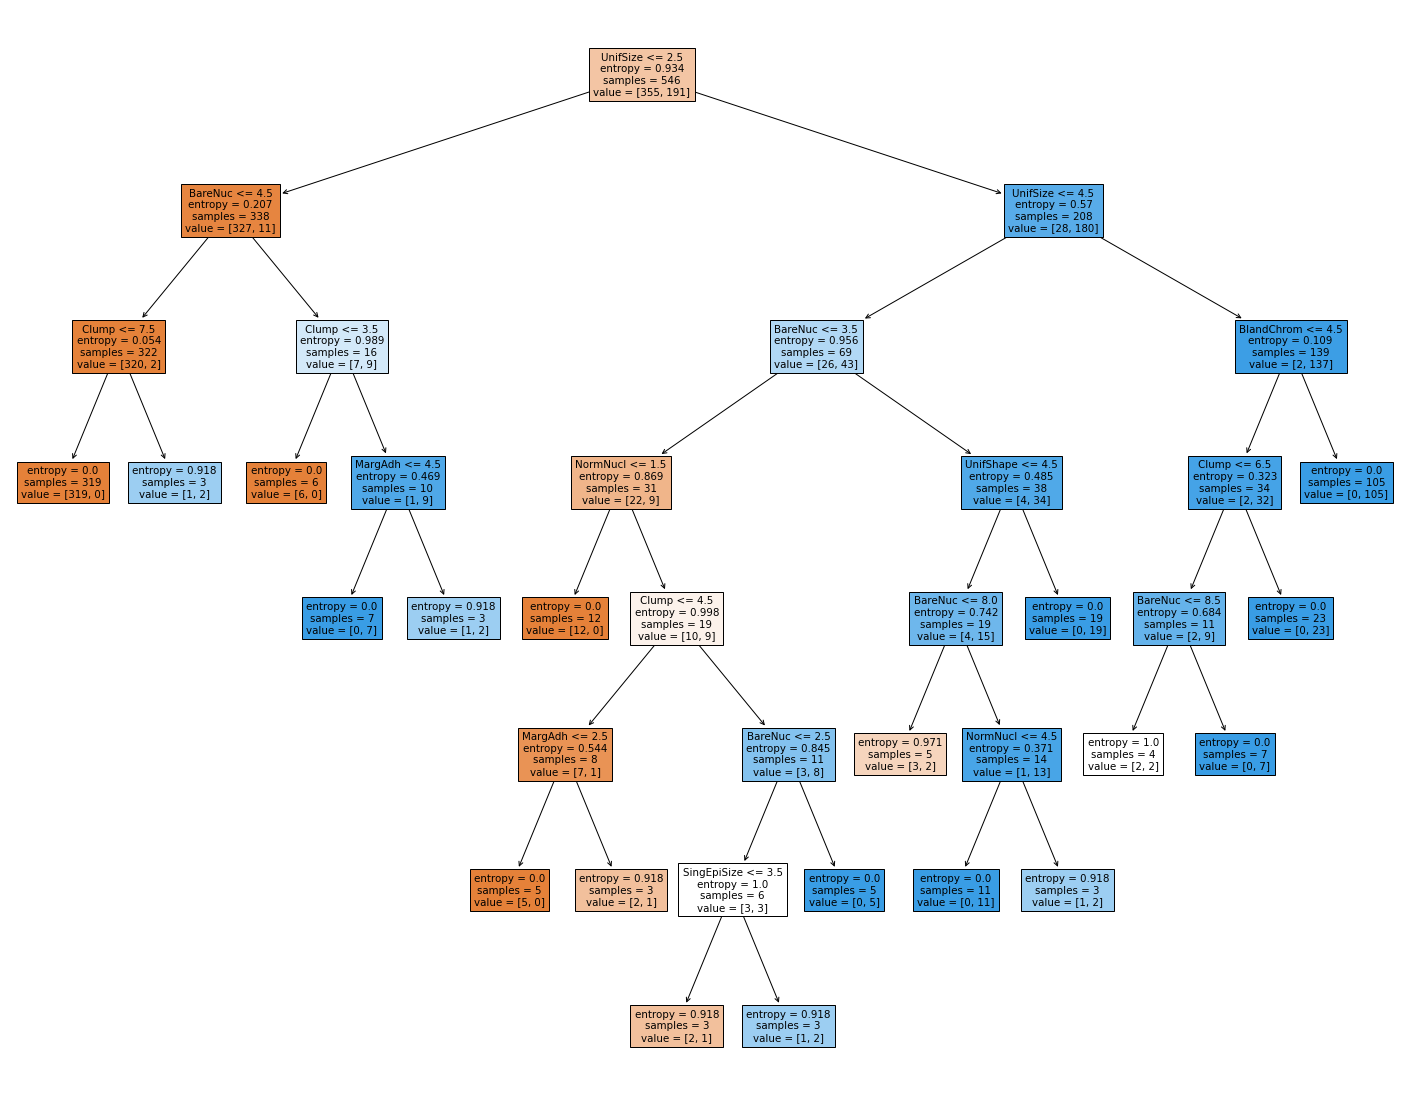

In [18]:
# Plot the decision tree
plot_decision_tree(custom_model, feature_names)

As you can see the tuned decision tree above is much simpler than the default decision tree model. We can see from each node, it's split feature and threshold, and entropy difference before and after a split.


## Coding exercise: build and visualize a decision tree with criterion='gini', max_depth = 15, and min_samples_leaf=5


{'accuracy': 0.9708029197080292,
 'recall': 0.9791666666666666,
 'precision': 0.94,
 'f1score': 0.9591836734693877}

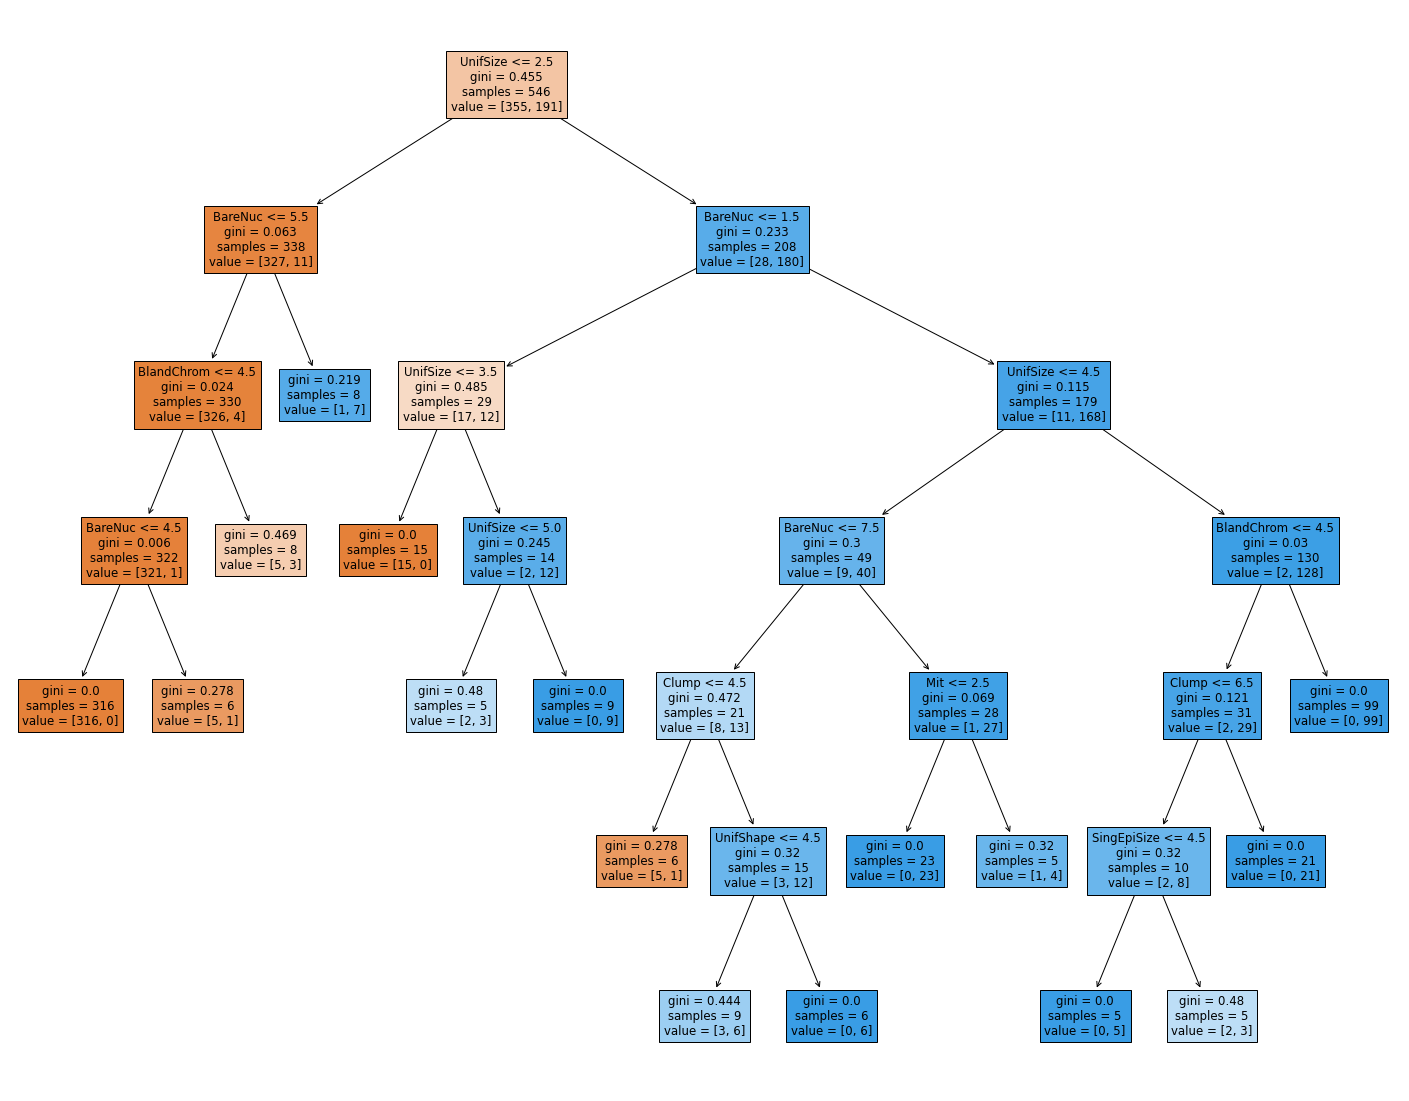

In [19]:
# Type your code here

# A- Initiate a model
custom_model = DecisionTreeClassifier(criterion='gini', max_depth=15, min_samples_leaf=5, random_state=rs)

# B- fit and evaluate the model
custom_model.fit(X_train, y_train.values.ravel())
preds = custom_model.predict(X_test)
display(evaluate_metrics(y_test, preds))

# C- Display the tree
plot_decision_tree(custom_model, feature_names)


<details><summary>Click here for a sample solution</summary>

```python
# Train a customized decision tree
custom_model = DecisionTreeClassifier(criterion='gini', max_depth=15, min_samples_leaf=5, random_state=rs)
custom_model.fit(X_train, y_train.values.ravel())
preds = custom_model.predict(X_test)
evaluate_metrics(y_test, preds)
# Plot the decision tree
plot_decision_tree(custom_model, feature_names)
```

</details>


## Tune hyperparameters


Lastly, let's try to find the optimized hyperparameters, which can produce the highest F1 score, via GridSearch cross-validation.


We define a `params_grid` dict object to contain the parameter candidates:


In [20]:
params_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5]
}

Then we create a default decision tree classifier to be tuned:


In [21]:
model = DecisionTreeClassifier(random_state=rs)

Ok, now we can use the `GridSearchCV` to search the best parameters generating the highest F1 score.


In [22]:
grid_search = GridSearchCV(estimator = model, # first introduce the model
                        param_grid = params_grid, # Second, the dictionary
                        scoring='f1', # Scoring metric
                        cv = 5, verbose = 1) # CV value is 5
grid_search.fit(X_train, y_train.values.ravel())
best_params = grid_search.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [23]:
best_params

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5}

So the best parameters are criterion=`gini`, max_depth=10, and min_samples_leaf=5.


## Coding exercise: build and visualize a decision tree with the best parameters


{'accuracy': 0.9708029197080292,
 'recall': 0.9791666666666666,
 'precision': 0.94,
 'f1score': 0.9591836734693877}

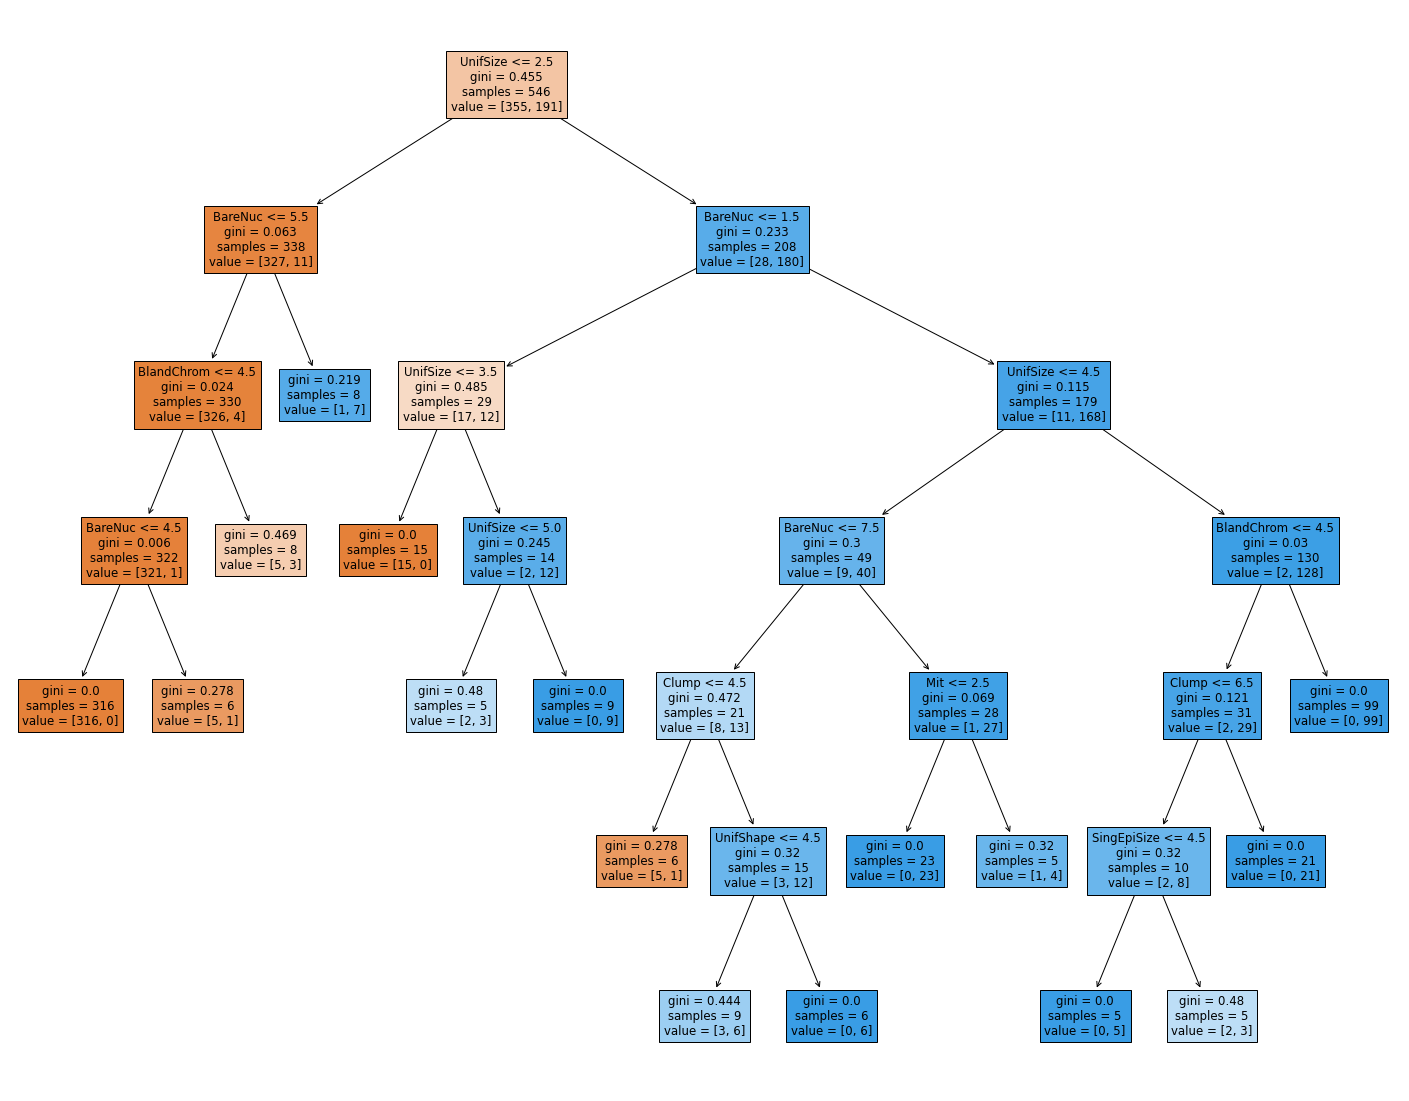

In [24]:
## Type your code here

# A- Initiate a model
custom_model = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=5, random_state=rs)

# B- fit and evaluate the model
custom_model.fit(X_train, y_train.values.ravel())
preds = custom_model.predict(X_test)
display(evaluate_metrics(y_test, preds))

# C- Display the tree
plot_decision_tree(custom_model, feature_names)


<details><summary>Click here for a sample solution</summary>

```python
# Train a customized decision tree
custom_model = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=5, random_state=rs)
custom_model.fit(X_train, y_train.values.ravel())
preds = custom_model.predict(X_test)
evaluate_metrics(y_test, preds)
# Plot the decision tree
plot_decision_tree(custom_model, feature_names)
```

</details>


## Next Steps


Now you have learned and applied the decision tree model to solve a real-world tumor type classification problem. You also visualized and fine-tuned the decision models. Later, you will continue learning other popular classification models with different structures, assumptions, cost functions, and application scenarios.


## Authors


[Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01)


### Other Contributors


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By | Change Description          |          |     |            |         |
| ----------------- | ------- | ---------- | --------------------------- | -------- | --- | ---------- | ------- |
| 2021-9-23         | 1.0     | Yan        | Created the initial version | 2022-2-9 | 1.1 | Steve Hord | QA pass |


Copyright © 2021 IBM Corporation. All rights reserved.
